In [153]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy.timeseries import BoxLeastSquares
import lightkurve as lk

In [ ]:
binaries = at.Table.read('/Users/apricewhelan/projects/apogee-dr16-vac/catalogs/lnK0.0_logL4.6_metadata.fits')

In [88]:
t = at.Table.read('/Users/apricewhelan/data/APOGEE_beta/allStar-r13-l33-58932beta.fits')
plx_snr = t['GAIA_PARALLAX'] / t['GAIA_PARALLAX_ERROR']
t = t[(plx_snr > 10) &
      (t['GAIA_PHOT_BP_MEAN_MAG'] > -5) & 
      (t['GAIA_PHOT_G_MEAN_MAG'] > -5) & 
      (t['J'] > -5) & (t['H'] > -5) & (t['K'] > -5)]
len(t)

427377

In [89]:
DM = coord.Distance(parallax=t['GAIA_PARALLAX']*u.mas).distmod.value
BPRP = t['GAIA_PHOT_BP_MEAN_MAG'] - t['GAIA_PHOT_RP_MEAN_MAG']
MG = t['GAIA_PHOT_G_MEAN_MAG'] - DM

In [90]:
JK = t['J'] - t['K']
MH = t['H'] - DM

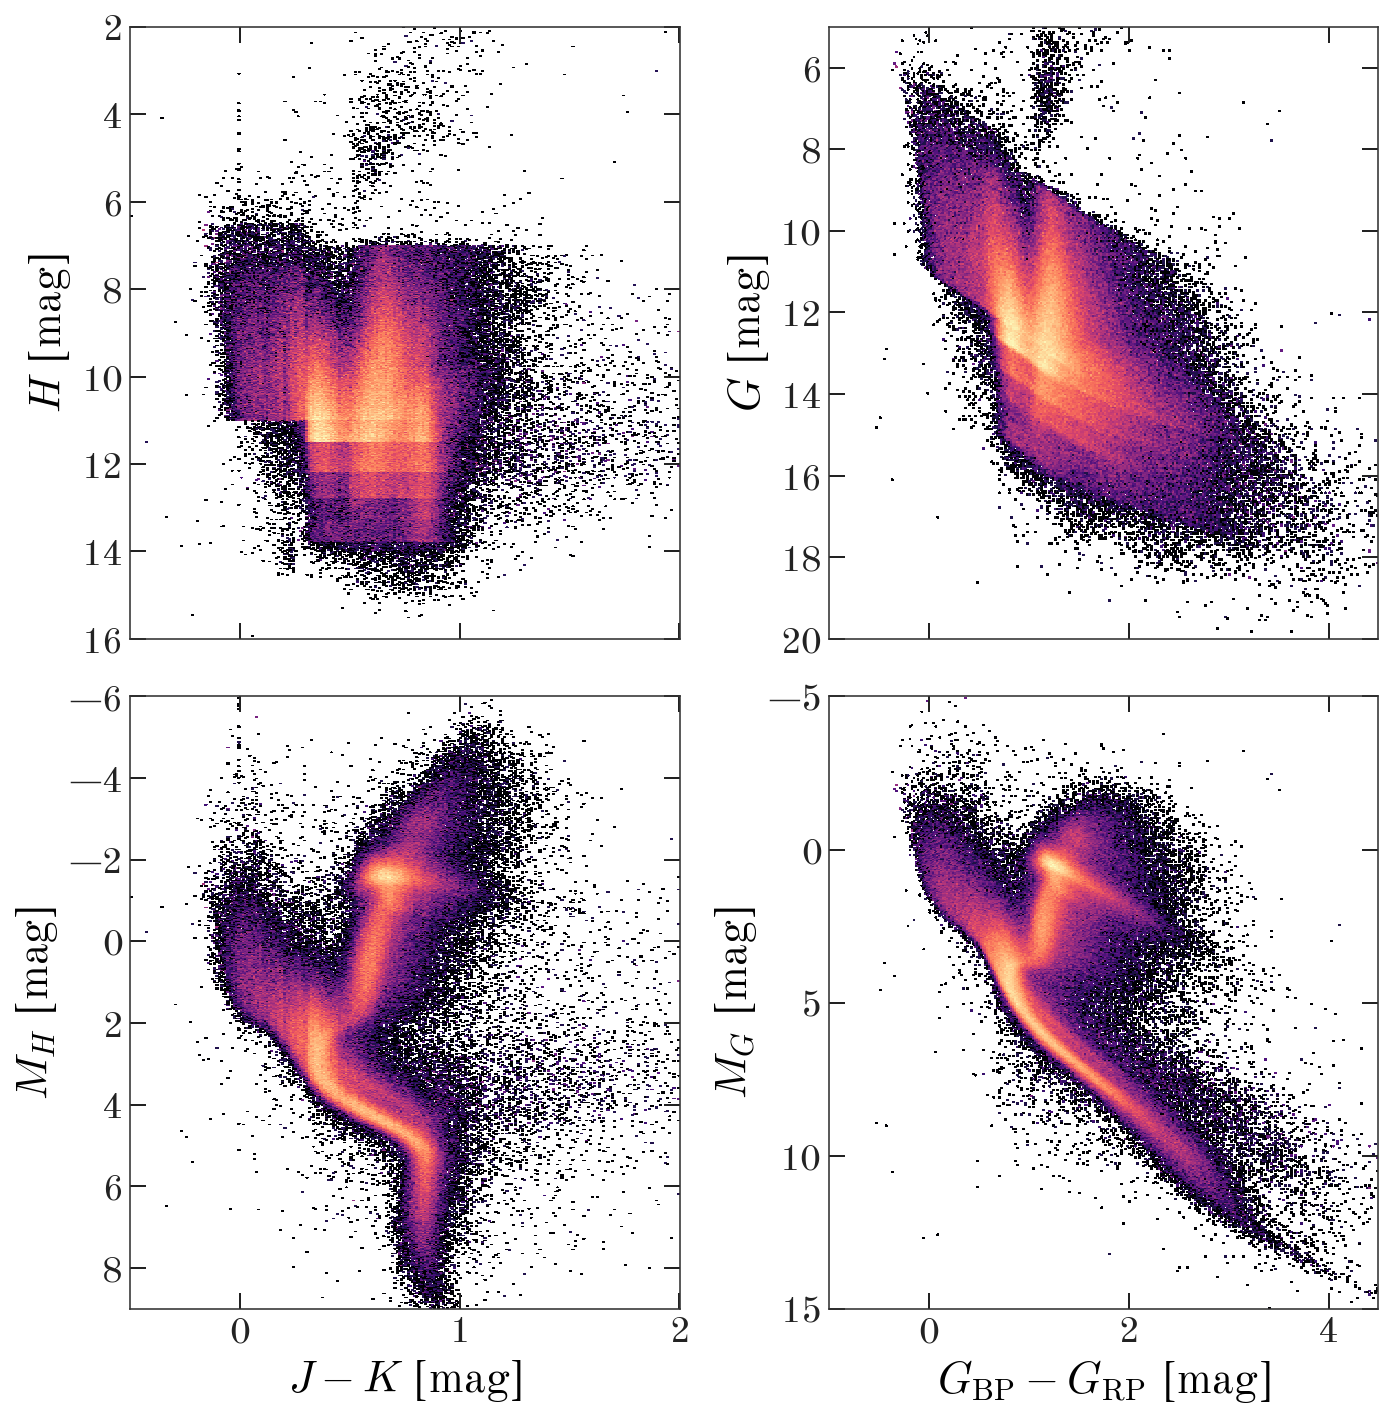

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10),
                         sharex='col')

# 2MASS:
ax = axes[0, 0]
bins = (np.arange(-0.5, 2+1e-3, 0.01),
        np.arange(2, 16+1e-3, 0.02))
ax.hist2d(JK, t['H'],
          bins=bins,
          norm=mpl.colors.LogNorm())

ax.set_xlim(bins[0].min(), bins[0].max())
ax.set_ylim(bins[1].max(), bins[1].min())

# ax.set_xlabel('$J-K$ [mag]')
ax.set_ylabel('$H$ [mag]')


# 2MASS
ax = axes[1, 0]
bins = (np.arange(-0.5, 2+1e-3, 0.01),
        np.arange(-6, 9+1e-3, 0.02))
ax.hist2d(JK, MH, 
          bins=bins,
          norm=mpl.colors.LogNorm())

ax.set_xlim(bins[0].min(), bins[0].max())
ax.set_ylim(bins[1].max(), bins[1].min())

ax.set_xlabel('$J-K$ [mag]')
ax.set_ylabel('$M_H$ [mag]')


# Gaia row:
ax = axes[0, 1]
bins = (np.arange(-1., 4.5+1e-3, 0.02),
        np.arange(5, 20+1e-3, 0.04))
ax.hist2d(BPRP, t['GAIA_PHOT_G_MEAN_MAG'], 
          bins=bins,
          norm=mpl.colors.LogNorm())

ax.set_xlim(bins[0].min(), bins[0].max())
ax.set_ylim(bins[1].max(), bins[1].min())

# ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$ [mag]')
ax.set_ylabel('$G$ [mag]')


ax = axes[1, 1]
bins = (np.arange(-1., 4.5+1e-3, 0.02),
        np.arange(-5, 15+1e-3, 0.04))
ax.hist2d(BPRP, MG, bins=bins,
          norm=mpl.colors.LogNorm())

ax.set_xlim(bins[0].min(), bins[0].max())
ax.set_ylim(bins[1].max(), bins[1].min())

ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$ [mag]')
ax.set_ylabel('$M_G$ [mag]')


fig.tight_layout()
fig.set_facecolor('w')

In [92]:
BPJ = t['GAIA_PHOT_BP_MEAN_MAG'] - t['J']

801


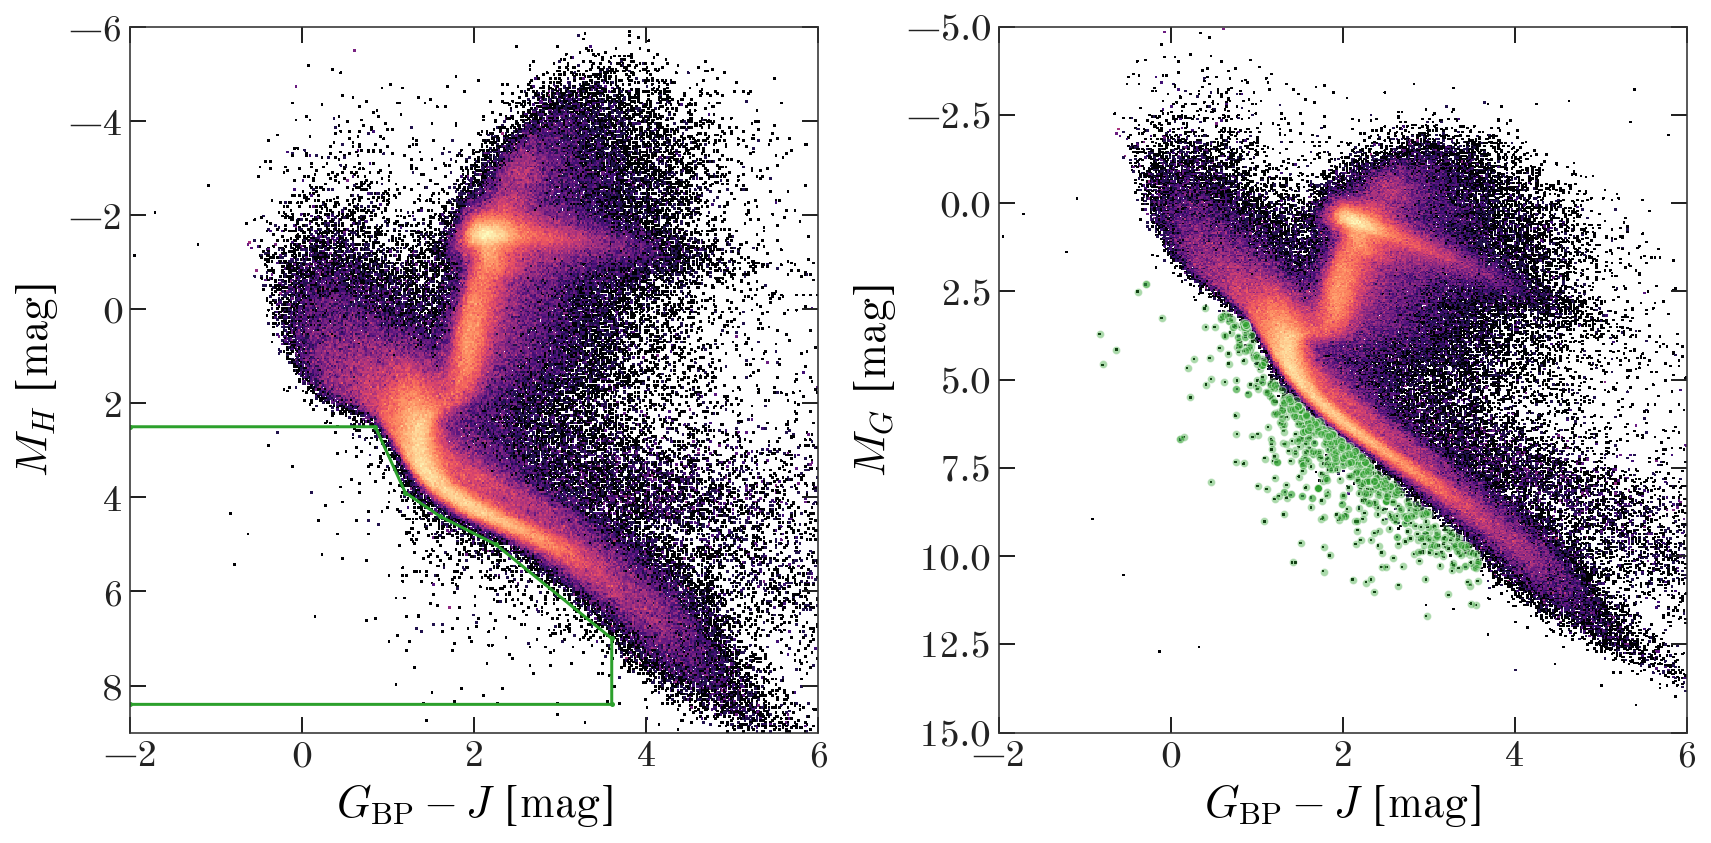

In [93]:
hbpj_nodes = np.array([[-2, 2.5], 
                       [0.85, 2.5],
                       [1.2, 3.9],
                       [1.6, 4.4],
                       [2.25, 5.],
                       [3.6, 7],
                       [3.6, 8.4],
                       [-2, 8.4]])
too_blue_path = mpl.path.Path(hbpj_nodes)
too_blue_mask = too_blue_path.contains_points(np.stack((BPJ, MH)).T)
print(too_blue_mask.sum())

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# 2MASS:
ax = axes[0]
bins = (np.arange(-2, 6+1e-3, 0.02),
        np.arange(-6, 9+1e-3, 0.04))
ax.hist2d(BPJ, MH,
          bins=bins,
          norm=mpl.colors.LogNorm())

ax.plot(hbpj_nodes[:, 0],
        hbpj_nodes[:, 1],
        color='tab:green')

ax.set_xlim(bins[0].min(), bins[0].max())
ax.set_ylim(bins[1].max(), bins[1].min())

# ax.set_xlim(-2, 4)
# ax.set_ylim(1.9, 8.5)

ax.set_xlabel(r'$G_{\rm BP}-J$ [mag]')
ax.set_ylabel('$M_H$ [mag]')

# Gaia:
ax = axes[1]
bins = (bins[0],
        np.arange(-5, 15+1e-3, 0.04))
ax.hist2d(BPJ, MG, bins=bins,
          norm=mpl.colors.LogNorm())
ax.plot(BPJ[too_blue_mask],
        MG[too_blue_mask],
        marker='o', mew=0.5, alpha=0.4, 
        ms=4, mfc='tab:green', mec='w', ls='none')

ax.set_xlim(bins[0].min(), bins[0].max())
ax.set_ylim(bins[1].max(), bins[1].min())

ax.set_xlabel(r'$G_{\rm BP}-J$ [mag]')
ax.set_ylabel('$M_G$ [mag]')


fig.tight_layout()
fig.set_facecolor('w')

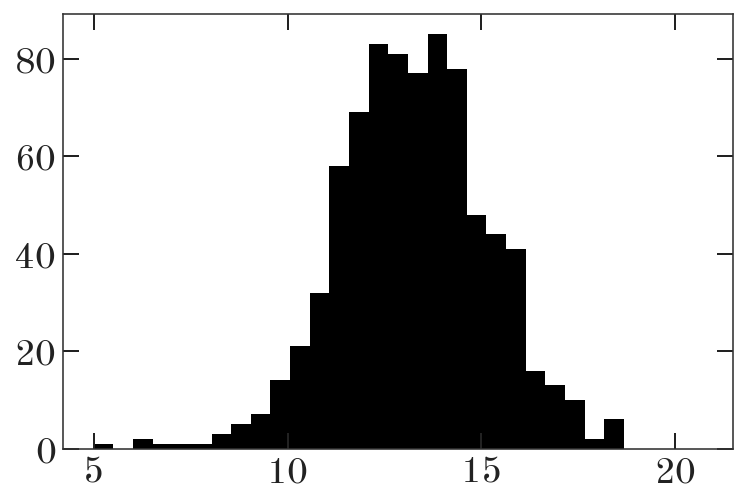

In [98]:
plt.hist(t['GAIA_PHOT_G_MEAN_MAG'][too_blue_mask], 
         bins=np.linspace(5, 20.7, 32));

# TESS

In [395]:
too_blue = t[too_blue_mask & 
             np.isin(t['APOGEE_ID'].astype(str), binaries['APOGEE_ID'].astype(str)) & 
             (t['GAIA_PHOT_G_MEAN_MAG'] < 13) & 
             (t['GAIA_PHOT_G_MEAN_MAG'] > 6)]
too_blue = at.join(too_blue, binaries, keys='APOGEE_ID')

too_blue = too_blue[too_blue['n_visits'] >= 5]
too_blue = too_blue[np.unique(too_blue['APOGEE_ID'], return_index=True)[1]]

too_blue_c = coord.SkyCoord(ra=too_blue['RA']*u.deg,
                            dec=too_blue['DEC']*u.deg)

len(too_blue)

7

In [417]:
i = 6
search_result = lk.search_targetpixelfile(too_blue_c[i], mission='TESS')
search_result

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (322.916729, 10.812573)>".


SearchResult containing 0 data products.

In [412]:
tpfs = search_result.download_all(quality_bitmask='default')

In [413]:
lc = None
for tpf in tpfs:
    clc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
    
    bg_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)
    n_bg_pix = bg_mask.sum()
    bg_lc_per_pixel = tpf.to_lightcurve(aperture_mask=bg_mask) / n_bg_pix
    bg_lc = bg_lc_per_pixel * tpf.pipeline_mask.sum()
    
    corrected_lc = clc - bg_lc.flux
    
    if lc is None:
        lc = corrected_lc
        
    else:
        lc.append(corrected_lc, inplace=True)

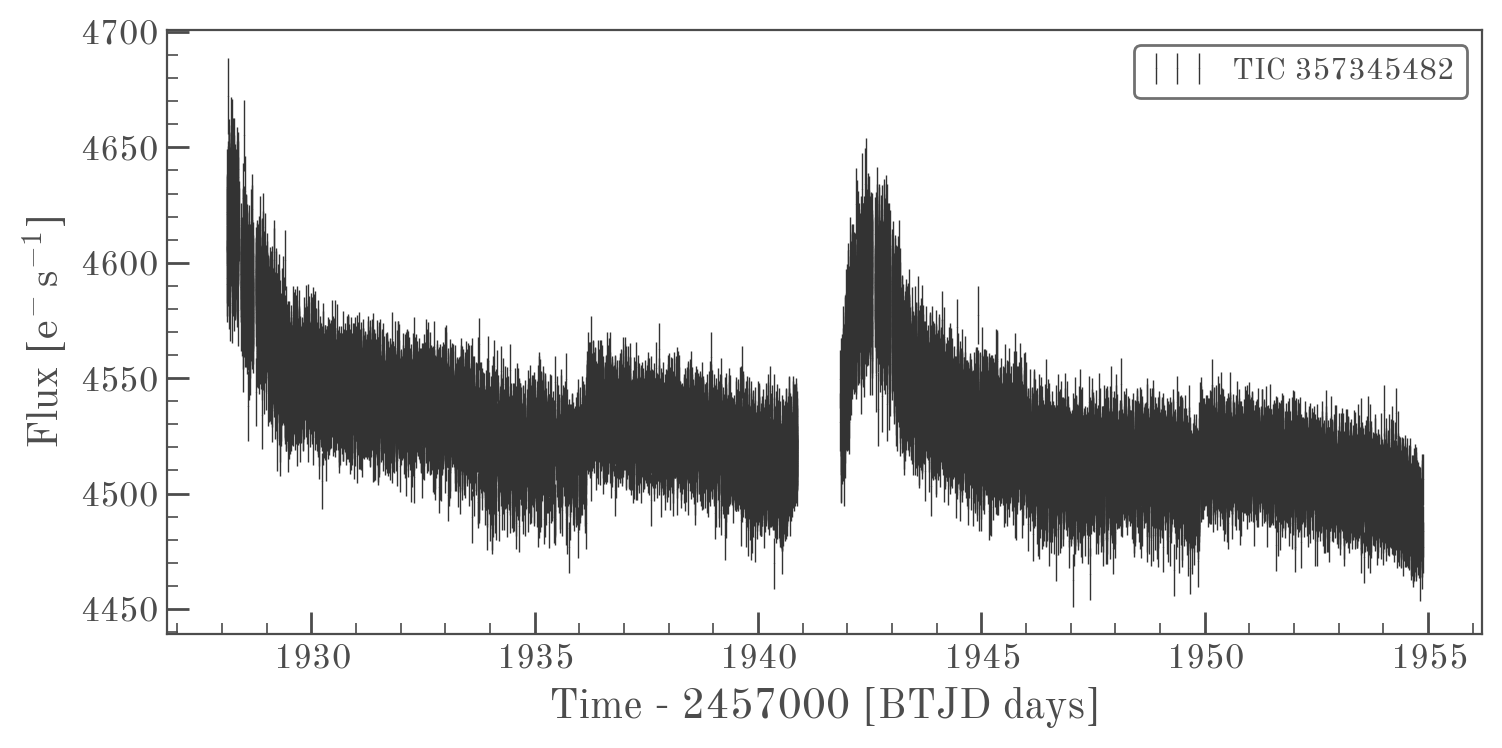

In [414]:
lc.errorbar();
# plt.xlim(1845, 1846)

In [403]:
# lc.flatten(window_length=1001).errorbar();

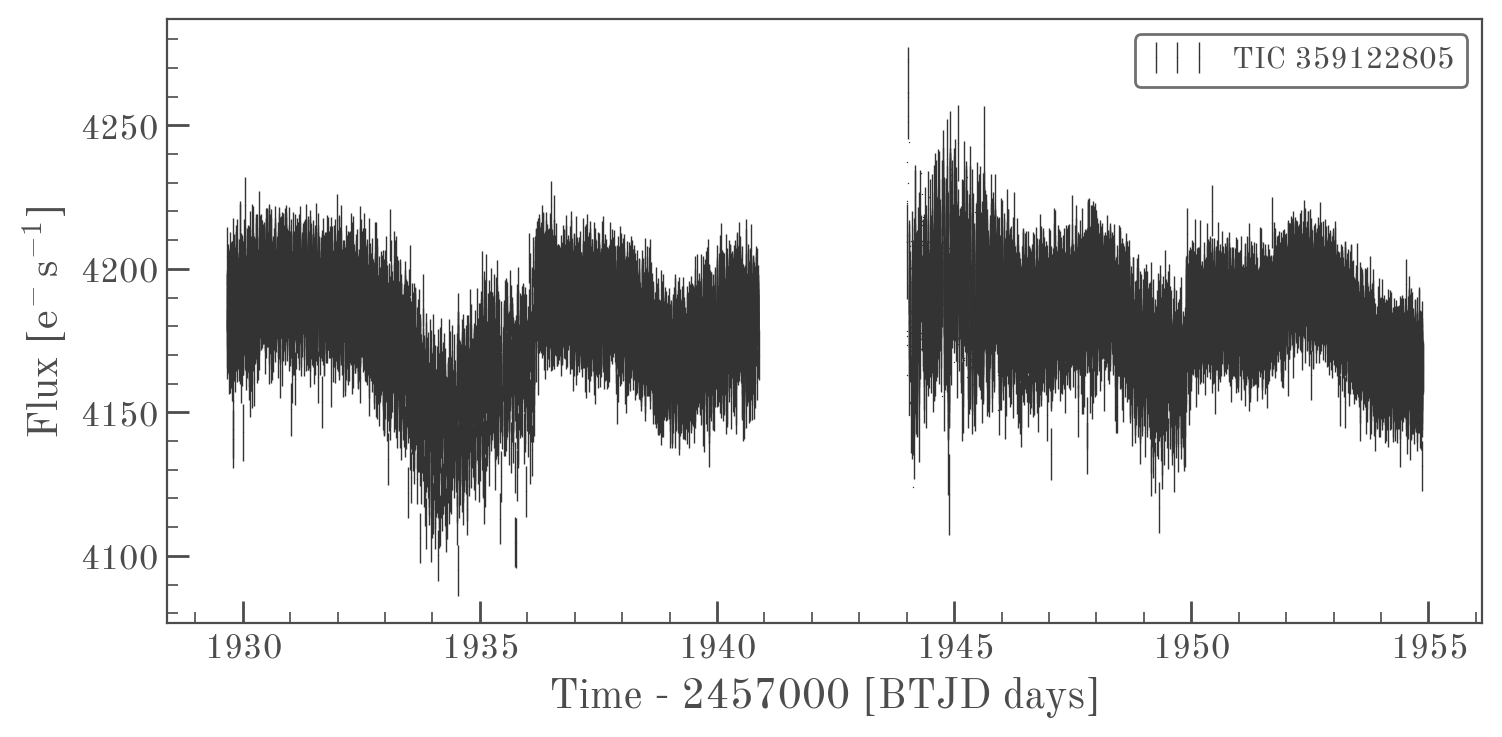

In [406]:
masked_lc = lc[(lc.time < 1941) | (lc.time > 1944)]  # .flatten(window_length=1001)
masked_lc = masked_lc[1000:] # .flatten(window_length=1001)

clipped_lc = masked_lc.remove_outliers(sigma=6)
clipped_lc.errorbar();

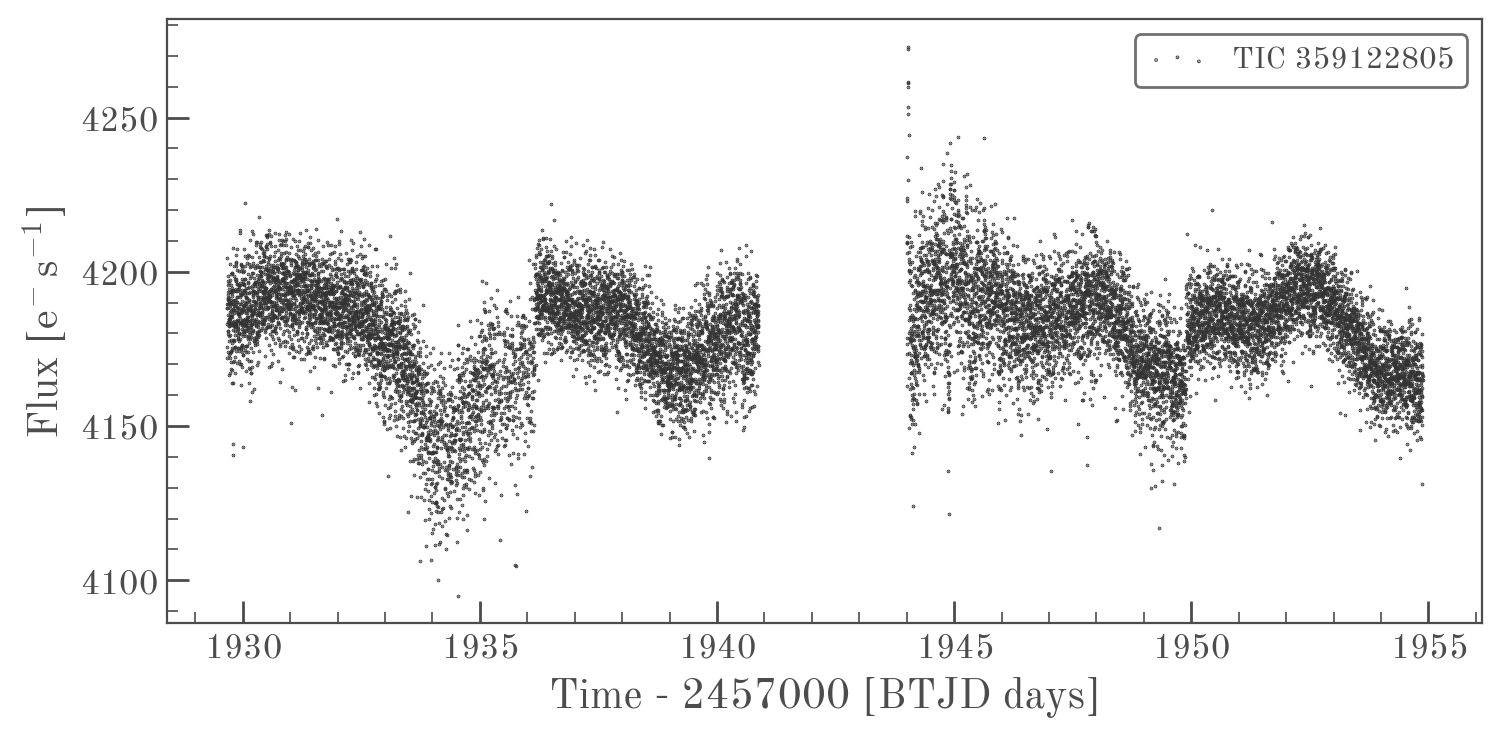

In [407]:
clipped_lc.scatter(s=0.1);

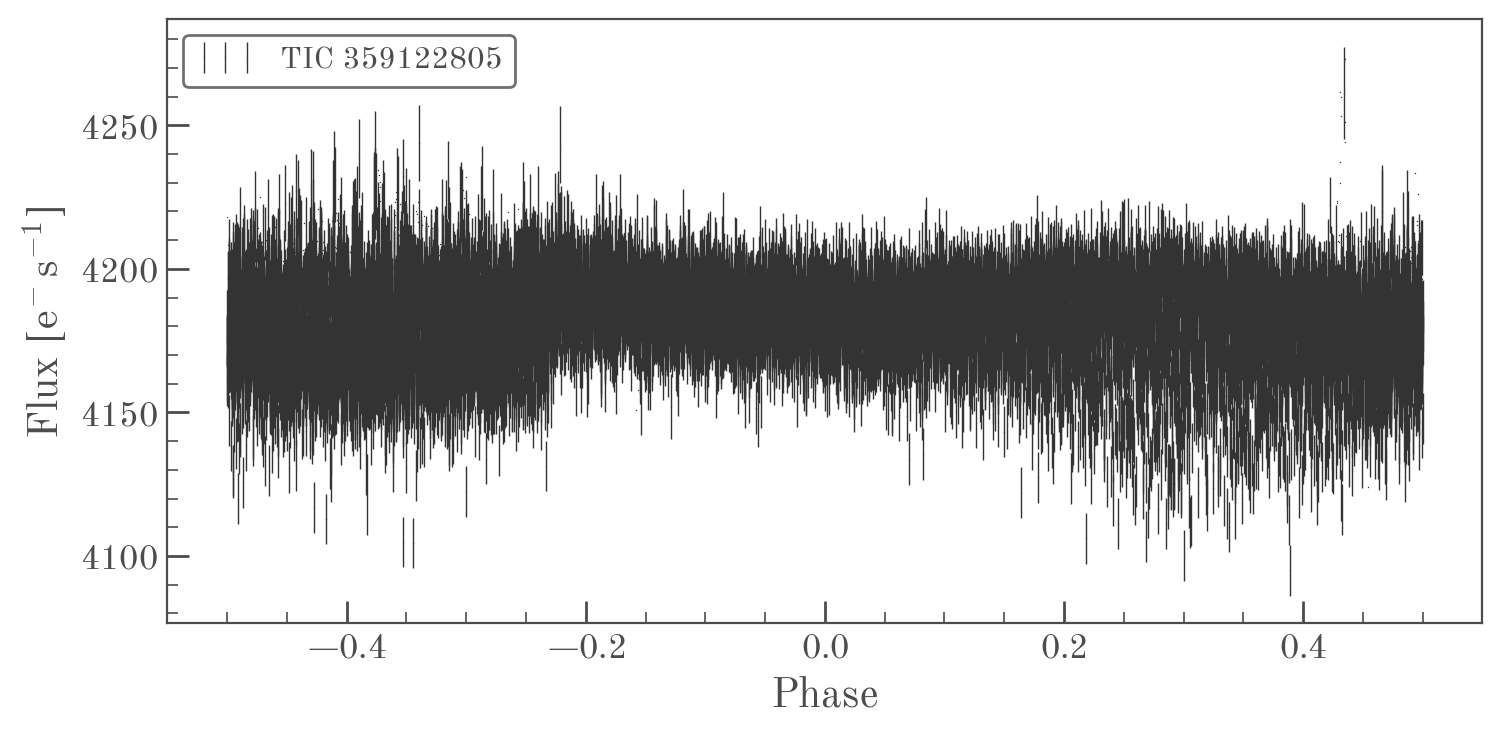

In [410]:
folded_lc = clipped_lc.fold(period=too_blue[i]['MAP_P'])
folded_lc.errorbar();

In [312]:
((2*u.Rearth) / (0.4*u.Rsun)).decompose()**2

<Quantity 0.00210125>

In [325]:
bg_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)
n_bg_pix = bg_mask.sum()
n_bg_pix

61

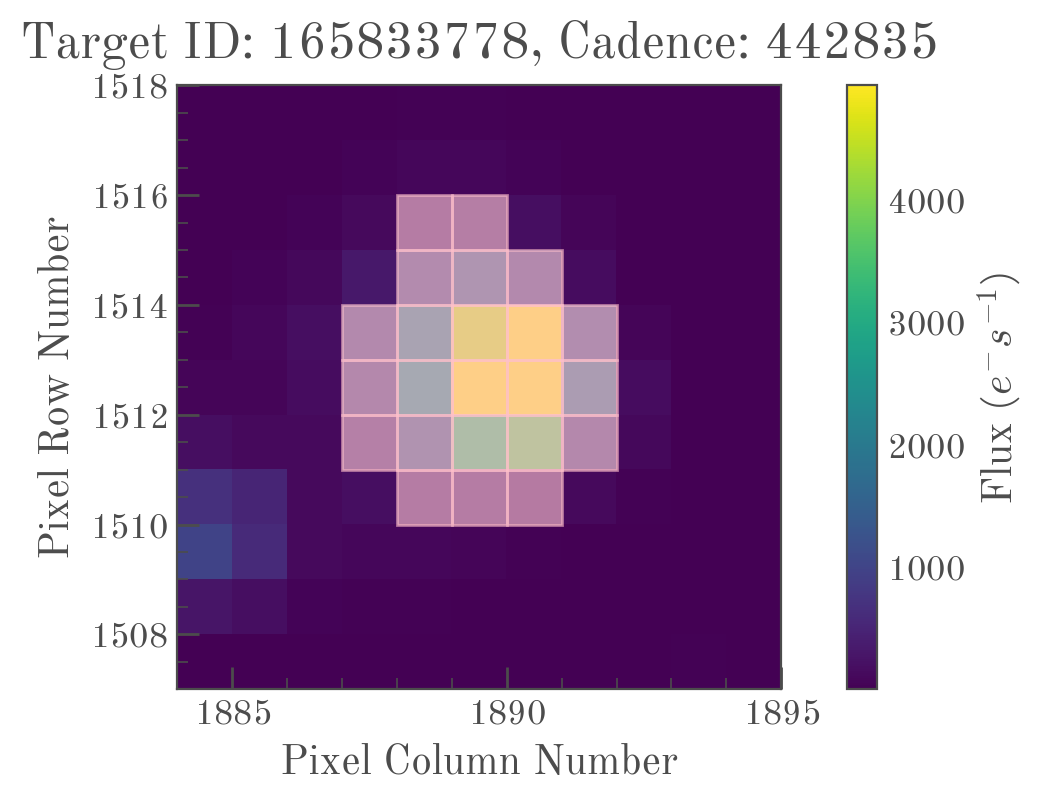

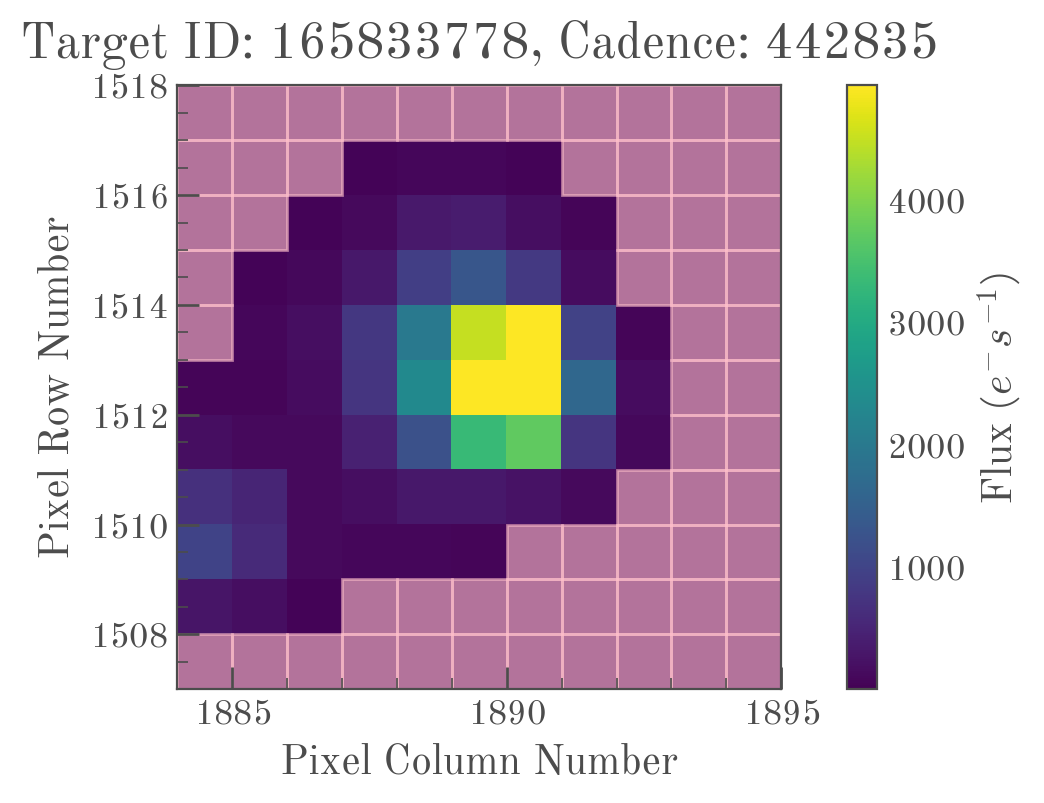

In [326]:
tpf.plot(aperture_mask=tpf.pipeline_mask);
tpf.plot(aperture_mask=bg_mask);

(1845.0, 1850.0)

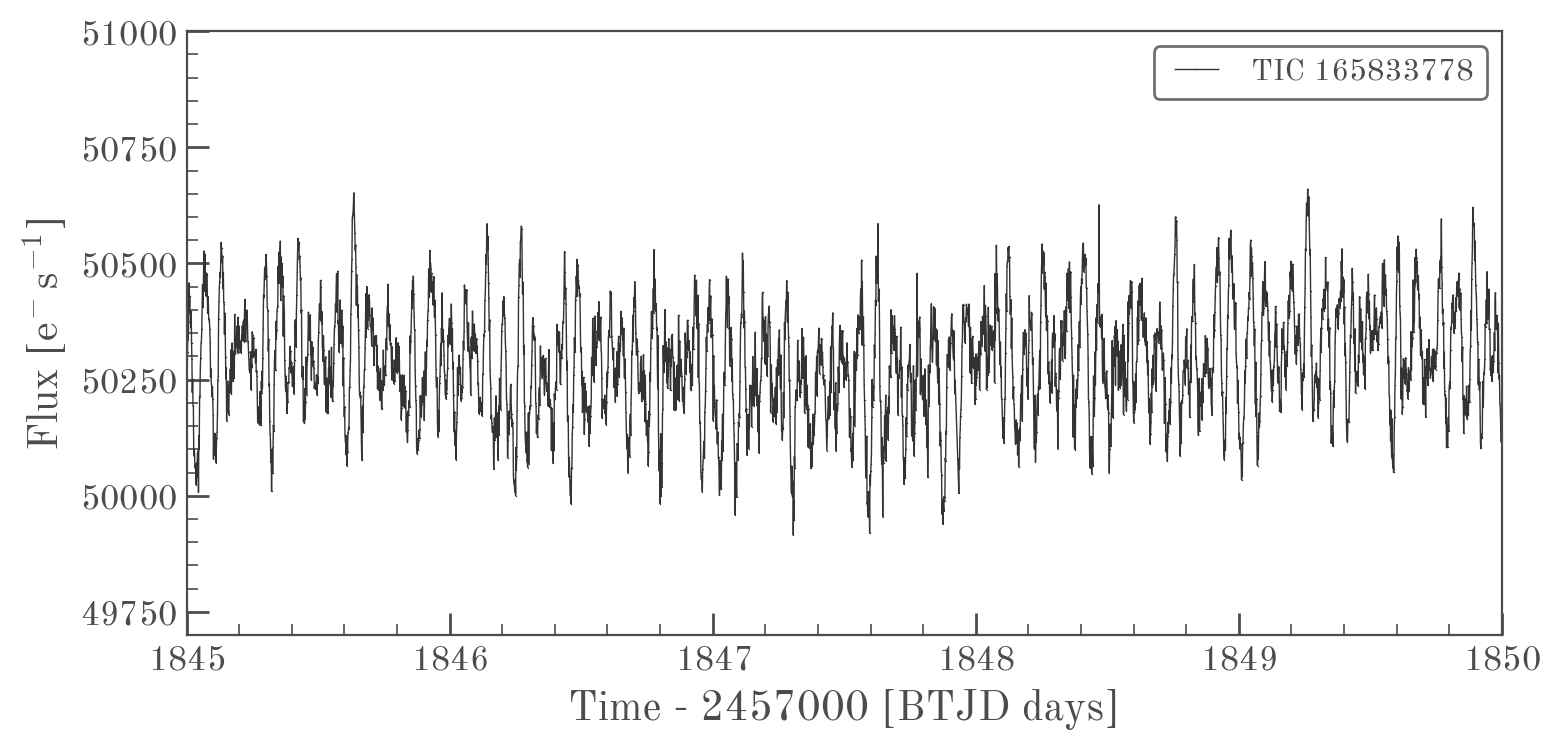

In [335]:
_ = lc.plot()
plt.ylim(4.97e4, 5.1e4)
plt.xlim(1845, 1850)

In [327]:
lc = tpf.to_lightcurve()

bg_lc_per_pixel = tpf.to_lightcurve(aperture_mask=bg_mask) / n_bg_pix
bg_lc = bg_lc_per_pixel * tpf.pipeline_mask.sum()

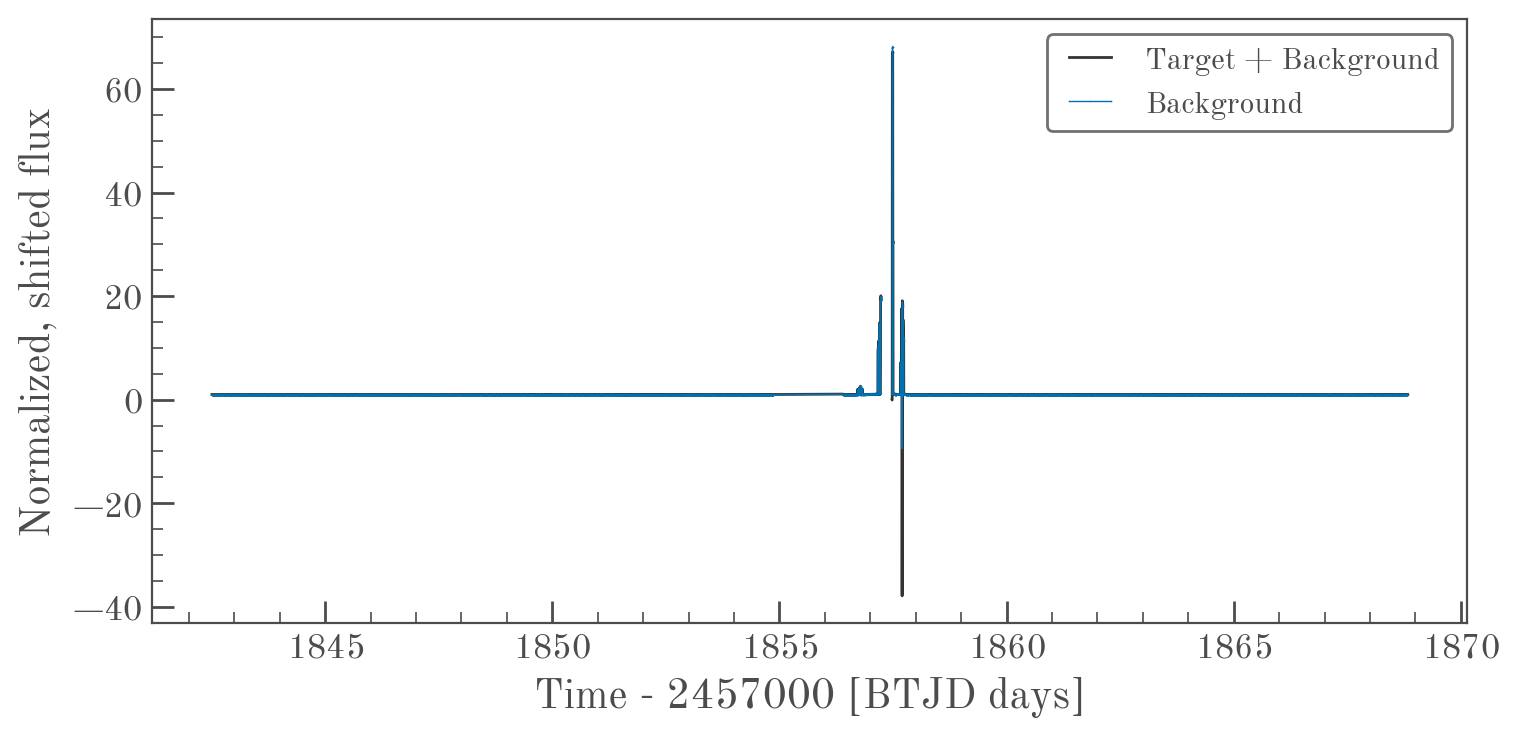

In [328]:
common_normalization = np.nanpercentile(lc.flux, 10)
ax = (lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(bg_lc / common_normalization +1).plot(ax=ax, normalize=False, label='Background',
                                       ylabel='Normalized, shifted flux');

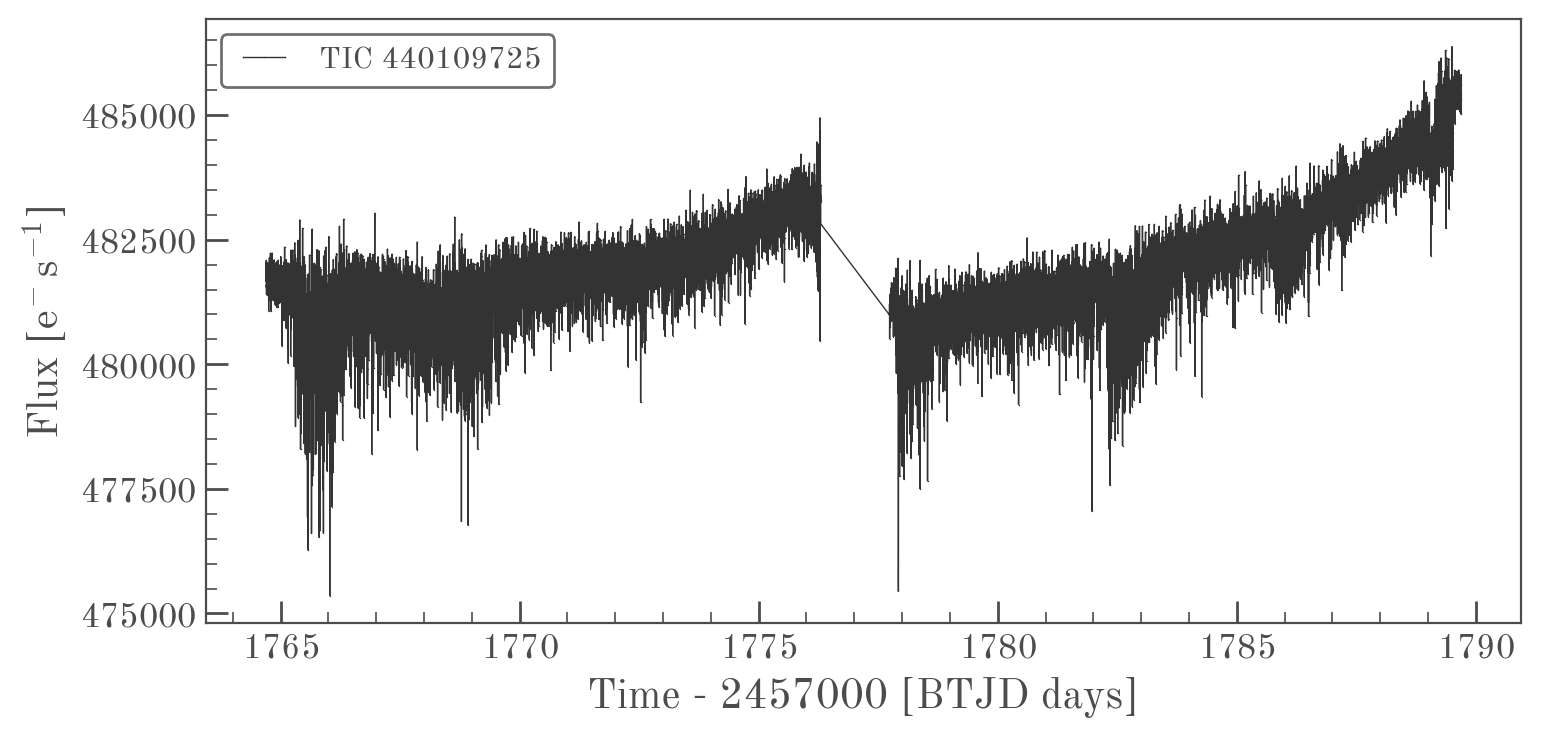

In [260]:
corrected_lc = lc - bg_lc.flux

corrected_lc.plot();

In [261]:
flat_lc = corrected_lc.flatten(window_length=1001)

In [ ]:
flat_lc.errorbar();

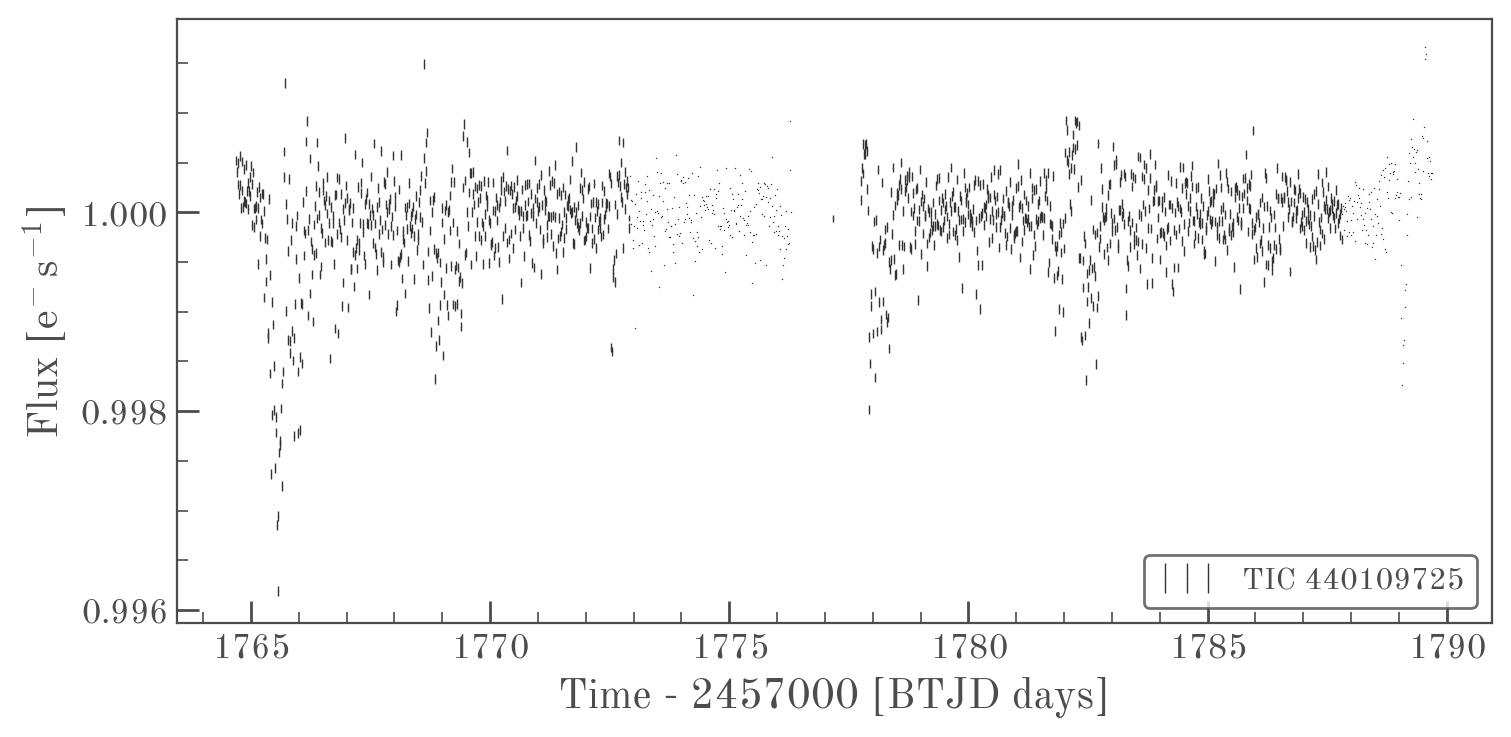

In [264]:
flat_lc.bin(binsize=10).errorbar();

In [239]:
tpfs = lk.search_tesscut(too_blue_c[8]).download_all(cutout_size=(25, 25))

In [240]:
len(tpfs)

1

In [241]:
tpf = tpfs[0]

In [242]:
target_mask = tpf.create_threshold_mask(threshold=50, reference_pixel='center')
n_target_pixels = target_mask.sum()

bg_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)
n_bg_pix = bg_mask.sum()

n_target_pixels, n_bg_pix

(19, 313)

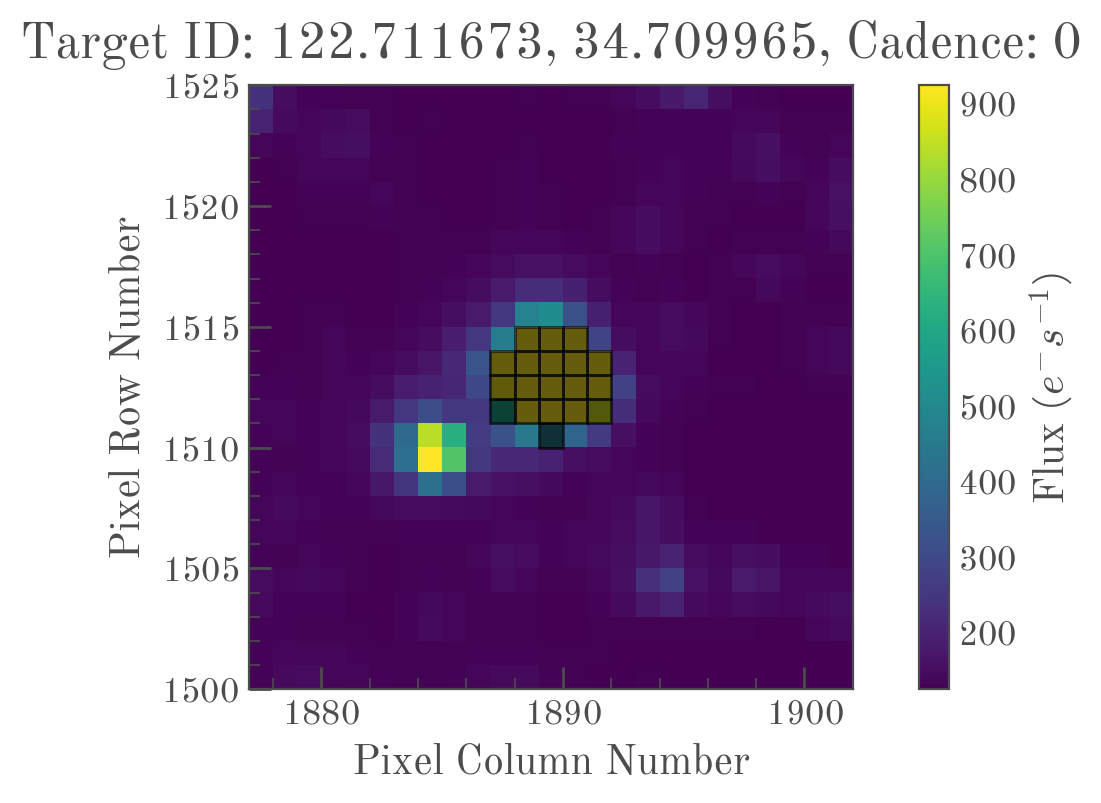

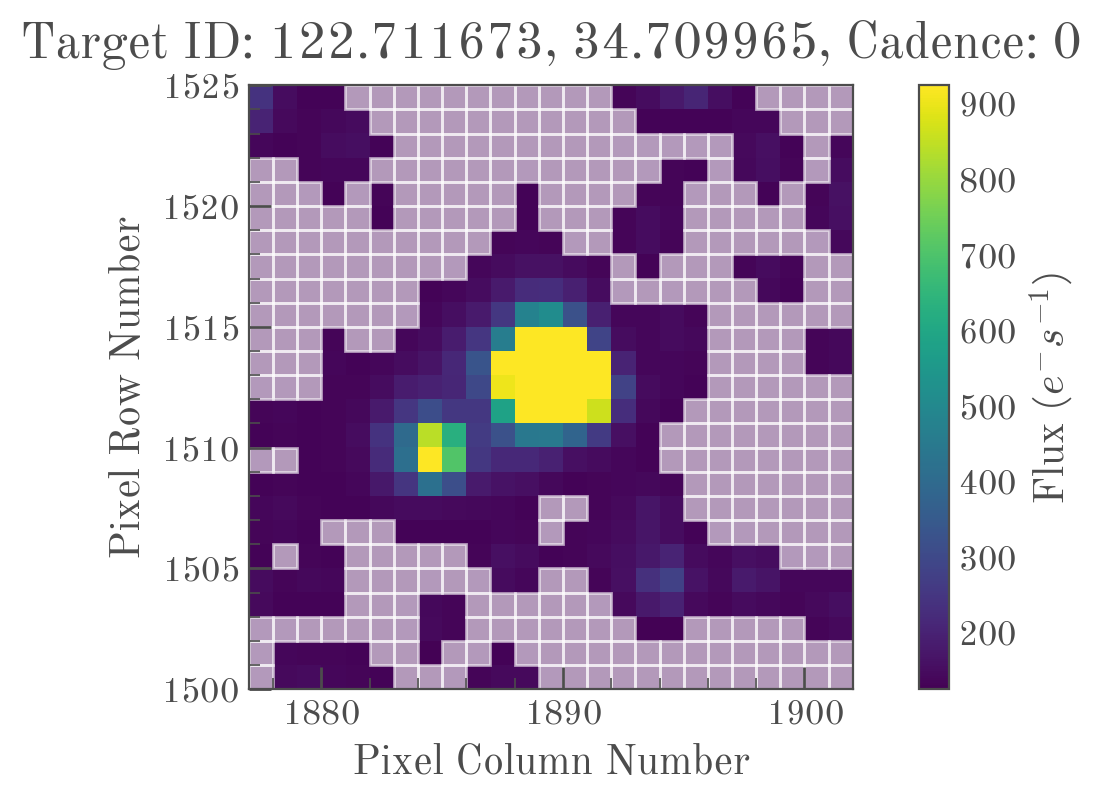

In [243]:
_ = tpf.plot(aperture_mask=target_mask, mask_color='k');
_ = tpf.plot(aperture_mask=bg_mask, mask_color='w');

In [244]:
lc = tpf.to_lightcurve(aperture_mask=target_mask)

In [245]:
bg_lc_per_pixel = tpf.to_lightcurve(aperture_mask=bg_mask) / n_bg_pix
bg_lc = bg_lc_per_pixel * n_target_pixels

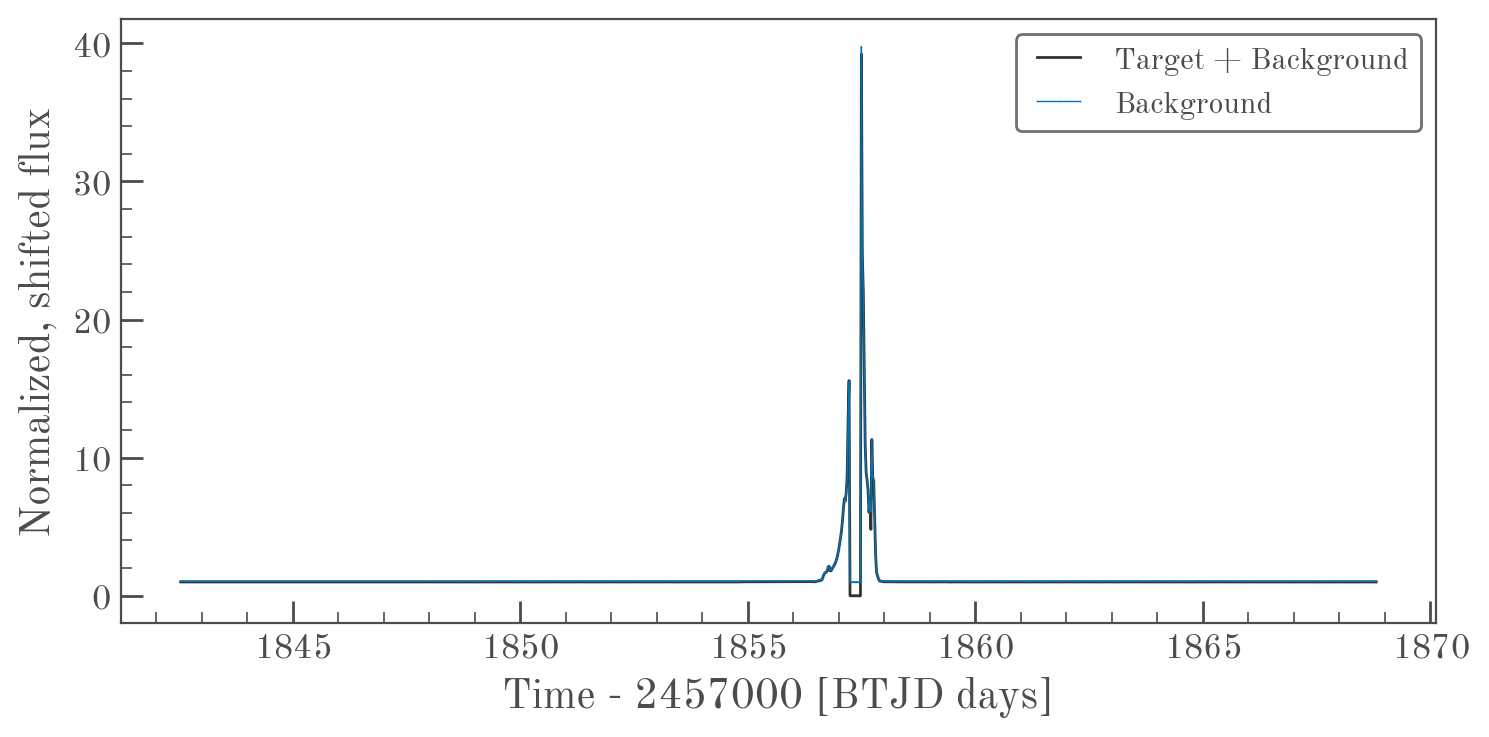

In [246]:
common_normalization = np.nanpercentile(lc.flux, 10)
ax = (lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(bg_lc / common_normalization +1).plot(ax=ax, normalize=False, label='Background',
                                       ylabel='Normalized, shifted flux');

In [247]:
corrected_lc = lc - bg_lc.flux

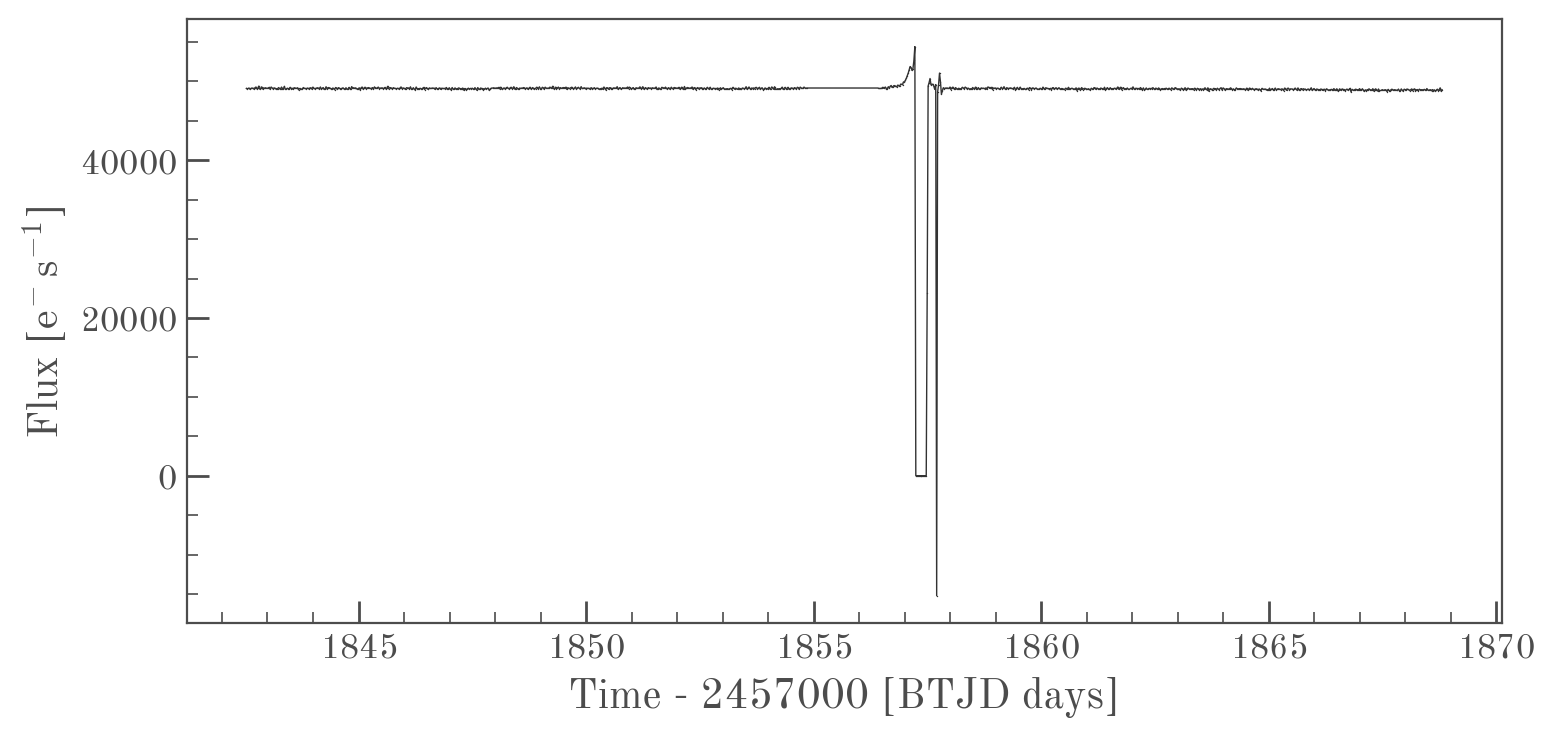

In [248]:
corrected_lc.plot();

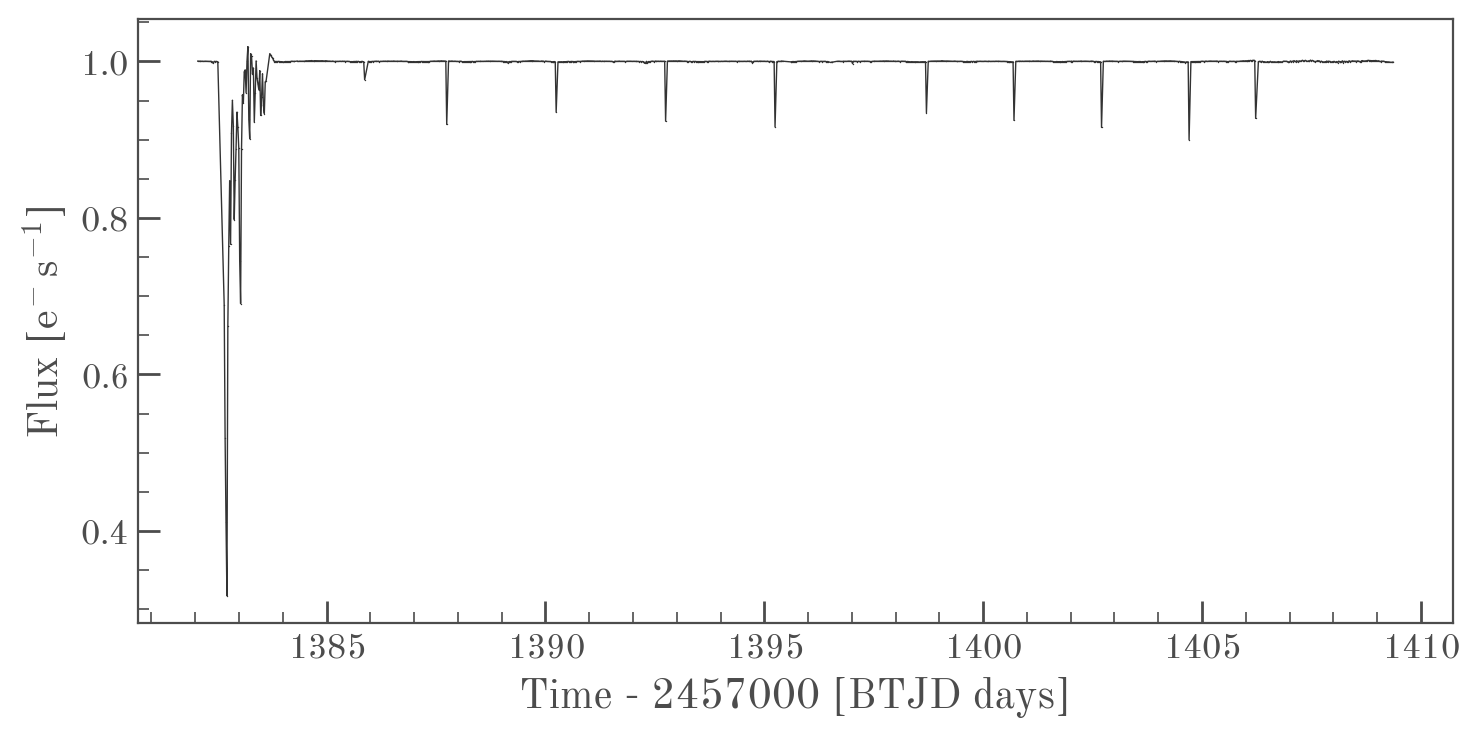

In [152]:
corrected_lc.flatten(101).plot();

In [186]:
sub_lc = corrected_lc[corrected_lc.time > 1385]

In [211]:
Pgrid = np.geomspace(0.5, 10, 8192)
T = sub_lc.time.max() - sub_lc.time.min()

_mask = np.ones_like(Pgrid).astype(bool)
for P in np.arange(1, 10+1e-3, 1):
    D = P**2 / (2*np.pi*T)
    _mask &= np.abs(Pgrid - P) > 2*D

In [227]:
pgram = sub_lc.to_periodogram(
    method='bls', 
    period=Pgrid[_mask],
    duration=[0.005, 0.01, 0.02, 0.04, 0.08])

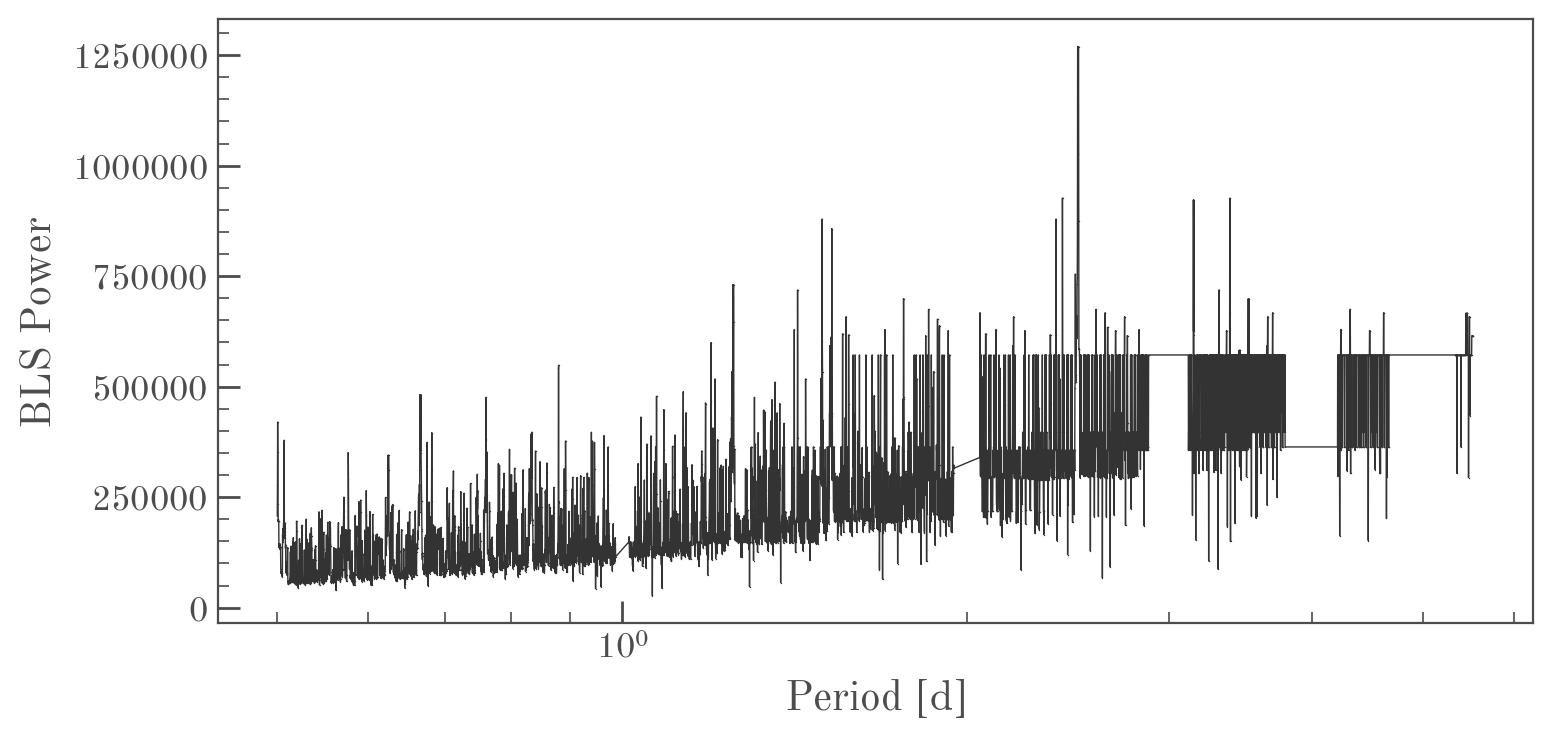

In [228]:
pgram.plot();
plt.xscale('log')

In [229]:
period_days = pgram.period_at_max_power.to_value(u.day)
t0 = pgram.transit_time_at_max_power
print(pgram.duration_at_max_power)

0.005 d


(-0.1, 0.1)

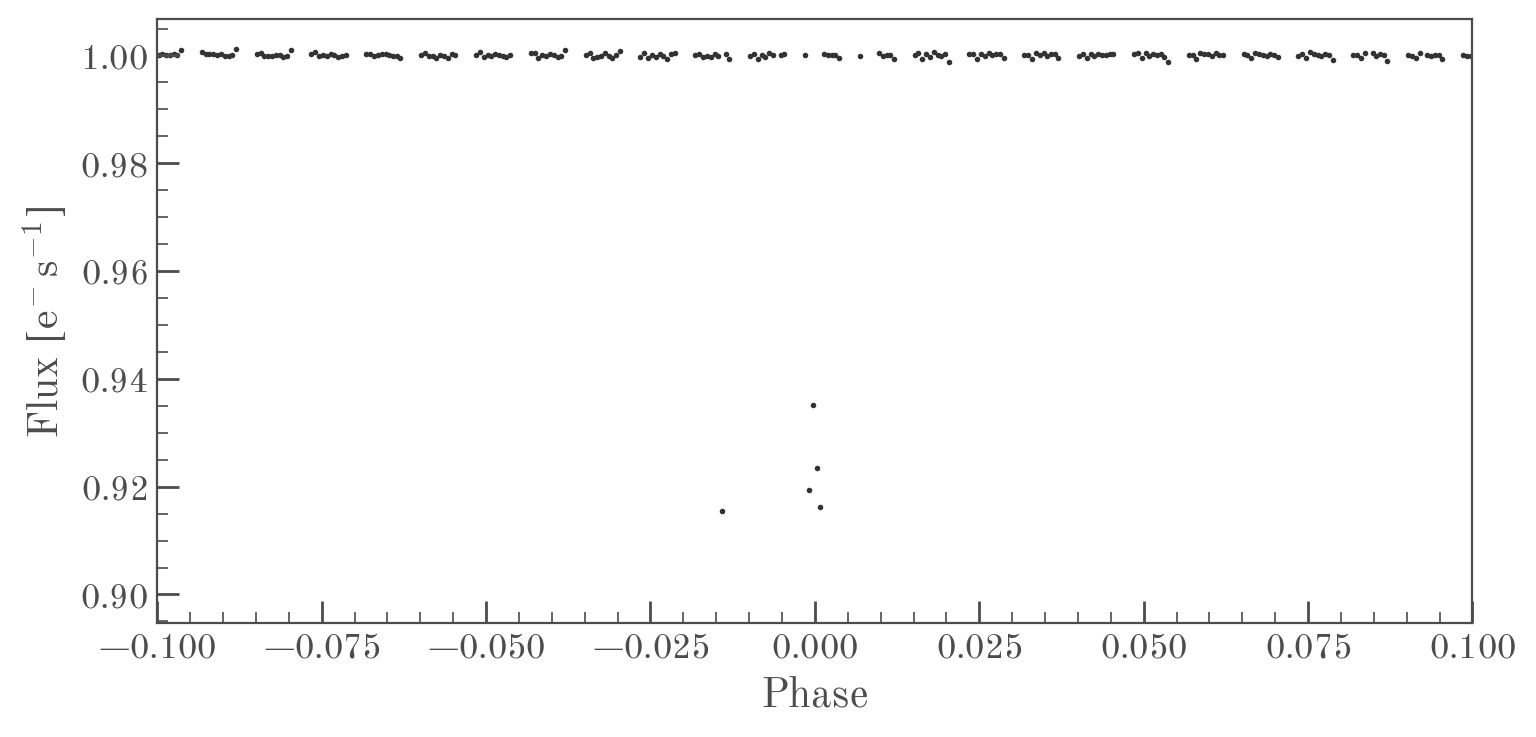

In [231]:
ax = sub_lc.flatten(101).fold(period_days, t0=t0).scatter();
ax.set_xlim(-0.1, 0.1)